# CSN8010 Practical Lab 3 Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

**Student Name: Hasyashri Bhatt**

**Student ID:9028501**

---

# **Introduction:**

We are trying to teach a computer to look at a picture and say whether it's a dog or a cat. This is done using a technique called Deep Learning.

There are two parts to this assignment:

- Build our own model (from scratch, called a "Vanilla CNN")
- Use a pre-trained model (VGG16 — a very smart model trained by researchers on millions of images), and fine-tune it.

We'll then compare the results and draw conclusions.

---

## The Dogs vs. Cats Dataset

* [Published](https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/) in 2007 by Microsoft.
* This dataset appears in Chollet, Deep Learing with Python 2nd edition, chapter 8 (book and associated notebook). 

The dataset can be obtained from:
* [Dogs versus Cats](https://www.kaggle.com/c/dogs-vs-cats) - The Kaggle competition
* [The Dataset](https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats) (with an Open Data license)

1. Download the dataset from Kaggle.
2. Extracted `train.zip` into a folder of your choice.  You should have **25,000** images, of about 600MB. The folder could be part of the repository, e.g.  `./data/kaggle_dogs_vs_cats/` . By the way, if you save it in the `./data/` folder it won't be tracked with Git, given that this folder appears in the `.gitignore` file. This is preferred, since `Git` and `Github` are not intended as data repositories.
3. The following code to create a small dataset of 1000 training images, 500 validation images and 1000 test images *per class*. This reduces the dataset from 25,000 images to 5000.
4. I manually delete the larger dataset as well as the zip file.

# Step 1: Loaded Data:

Originally dataset was 25000 images so I ran below code to create smaller dataset which is about 5000 images.and after I commented this codeblock to avoid use of original dataset.

In [ ]:

#import os, shutil, pathlib
#from PIL import Image

#original_dir = pathlib.Path("./data/kaggle_dogs_vs_cats/train")
#new_base_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")
#target_size = (224, 224)

#def make_subset(subset_name, start_index, end_index):
    #for category in ("cat", "dog"):
        #dir = new_base_dir / subset_name / category
        #os.makedirs(dir)
        #fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        #for fname in fnames:
           #src_path = original_dir / fname
           #dst_path = dir / fname
           #with Image.open(src_path) as img:
                #img = img.convert("RGB").resize(target_size)
                #img.save(dst_path)
#make_subset("train", start_index=0, end_index=1000)
#make_subset("validation", start_index=1000, end_index=1500)
#make_subset("test", start_index=1500, end_index=2500)


**Dataset Preparation and Resizing**

The original Dogs vs Cats dataset contains images of varying sizes and large file size. To make the dataset more manageable for training and sharing (e.g., uploading to GitHub), I created a smaller subset containing 5000 images (2500 cats and 2500 dogs) with the following steps:

- Selected 5000 images from the original dataset.
- Resized all images to 224×224 pixels to ensure uniform input size for CNN models like Vanilla CNN and 
  VGG16.
- Saved the resized images in a new folder structure:
- kaggle_dogs_vs_cats_small/train/cat, kaggle_dogs_vs_cats_small/train/dog, etc.

The resizing significantly reduced the total dataset size, bringing it under 100MB without compromising image quality necessary for model training.

This smaller dataset is optimized for efficient training and easy sharing without losing the essential features for classification.

- Training set (2,000 images: 1,000 cats, 1,000 dogs) – what the model learns from.
- Validation set (1,000 images) – to check how well the model is learning during training.
- Test set (2,000 images) – to test the model at the end, like a final exam.

And resized all images to 224×224 pixels (required for VGG16).

----

# Step 2: Exploratory Data Analysis (EDA)


What Is EDA?
Exploratory Data Analysis (EDA) is like getting to know your data before starting the actual work. Think of it like checking your ingredients before cooking.

In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "./data/kaggle_dogs_vs_cats_small"


In [4]:
#  Step 1: Create DataFrame with image metadata
def create_image_dataframe(base_dir, sample_size=200):
    data = []
    for subset in ["train", "validation", "test"]:
        for label in ["cat", "dog"]:
            folder = os.path.join(base_dir, subset, label)
            filenames = os.listdir(folder)[:sample_size // 6]
            for fname in filenames:
                path = os.path.join(folder, fname)
                try:
                    with Image.open(path) as img:
                        img = img.convert("RGB")
                        width, height = img.size
                        mode = img.mode
                        mean_pixel = np.mean(np.array(img))
                        data.append({
                            "filename": fname,
                            "subset": subset,
                            "label": label,
                            "width": width,
                            "height": height,
                            "mode": mode,
                            "mean_pixel_value": mean_pixel
                        })
                except:
                    continue
    return pd.DataFrame(data)

df_images = create_image_dataframe(base_dir)
print(f"Total images: {len(df_images)}")




Total images: 198


**Explaination:**

The code samples about 33 images from each of 6 groups (3 subsets × 2 labels), resulting in 198 images total. This is why the output shows "Total images: 198" instead of 200—due to integer division and equal distribution across groups.

In [5]:

# Step 2: Show statistics (image shape, color mode, pixel intensity)
print("=== Dataset Overview ===")
print(df_images["label"].value_counts())
print("\n=== Subset Distribution ===")
print(df_images["subset"].value_counts())
print("\n=== Color Modes ===")
print(df_images["mode"].value_counts())



=== Dataset Overview ===
label
cat    99
dog    99
Name: count, dtype: int64

=== Subset Distribution ===
subset
train         66
validation    66
test          66
Name: count, dtype: int64

=== Color Modes ===
mode
RGB    198
Name: count, dtype: int64


**Explaination:**

**Dataset Overview:**
- The dataset is perfectly balanced with 99 images each of cats and dogs.
**Subset Distribution:**
- The images are evenly split across the three subsets — 66 images in train, validation, and test each.
**Color Modes:**
- All images are in RGB color mode, confirming consistent color format throughout the dataset.

In [6]:
#  Step 3: Summary statistics (image size, pixel values)
print("\n=== Numeric Summary ===")
print(df_images.describe())


=== Numeric Summary ===
       width  height  mean_pixel_value
count  198.0   198.0        198.000000
mean   224.0   224.0        114.352976
std      0.0     0.0         25.845491
min    224.0   224.0         53.546011
25%    224.0   224.0         97.163008
50%    224.0   224.0        111.326278
75%    224.0   224.0        128.745302
max    224.0   224.0        198.502843


**Explaination:**

This table shows basic statistics about the images in the sample. All images are 224×224 pixels, so width and height are always 224. The average brightness (mean pixel value) is about 114, with most images ranging from 54 to 199. This means the images have similar sizes and a moderate range of brightness levels.

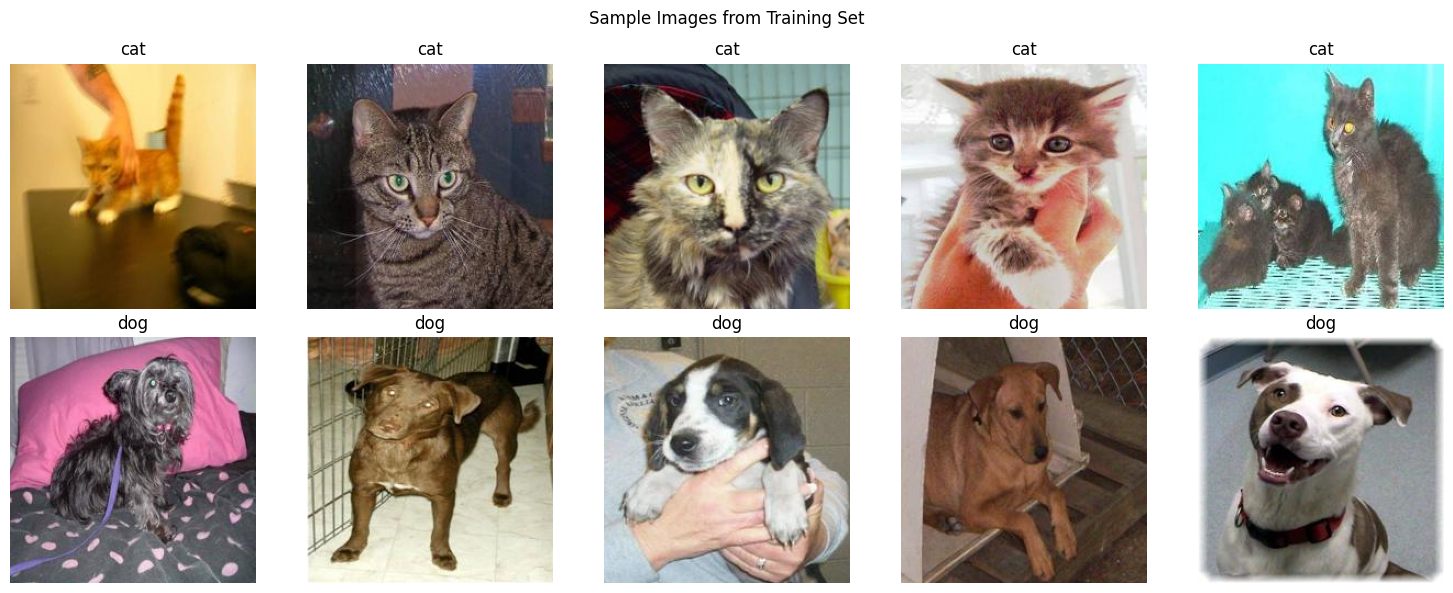

In [7]:
#  Step 4: Visualize sample images
def show_sample_images(base_dir):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, category in enumerate(["cat", "dog"]):
        folder = os.path.join(base_dir, "train", category)
        sample_files = os.listdir(folder)[:5]
        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"{category}")
            axs[i, j].axis("off")
    plt.suptitle("Sample Images from Training Set")
    plt.tight_layout()
    plt.show()

show_sample_images(base_dir)


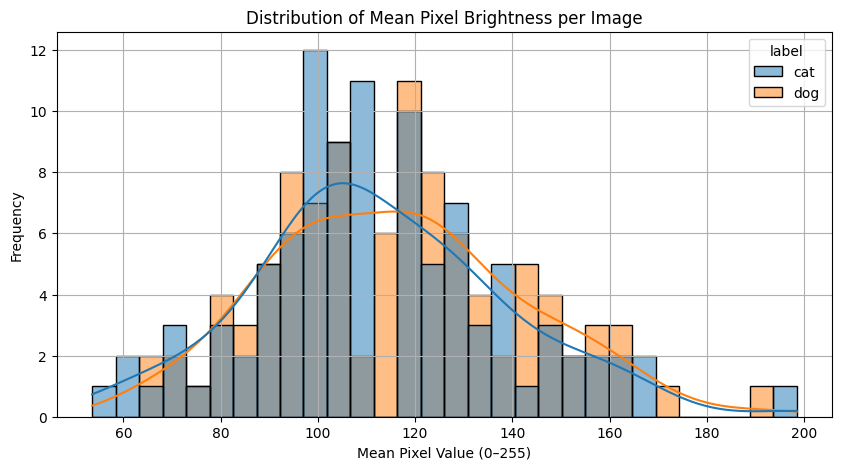

In [8]:
#  Step 5: Visualize pixel intensity distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df_images, x="mean_pixel_value", hue="label", bins=30, kde=True)
plt.title("Distribution of Mean Pixel Brightness per Image")
plt.xlabel("Mean Pixel Value (0–255)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

**Explaination**

This graph shows the distribution of average pixel brightness per image for cats and dogs. Most images fall between brightness values of 90 and 130, with cat images slightly darker on average. There’s a large overlap between the two classes, suggesting brightness alone isn’t a strong feature for classification. However, the plot helps identify potential dataset bias or preprocessing needs, like normalization, to ensure fair model training.

# Step 3: Build a Vanilla CNN (from scratch)

**What is a CNN?**
A Convolutional Neural Network (CNN) is a special type of model used to work with images. It learns to detect shapes, edges, colors — and finally, what is in the image (cat or dog).

**Steps:**
- Used layers like Conv2D, MaxPooling2D, Flatten, and Dense
- Used Adam optimizer
- Used ModelCheckpoint to save the best version of the model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_vanilla_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification: dog or cat
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [10]:
# Model summary for Vanilla CNN
vanilla_cnn = build_vanilla_cnn()
vanilla_cnn.summary()

c:\Users\habha\Downloads\lab 3 vanilaa CNN and vgg 16\Practical3_Vanilla_CNN_and_vgg16\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Explaination**

This CNN model processes 224×224 RGB images through three convolution and pooling layers to extract features, then flattens the output and passes it through two dense layers for binary classification (e.g., cat vs. dog). Most of the model's 11 million parameters come from the large dense layer after flattening. The final output layer has one neuron with likely a sigmoid activation for binary prediction.

### Train the model:

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

model = build_vanilla_cnn()
checkpoint_cb = callbacks.ModelCheckpoint("vanilla_best.h5", save_best_only=True)

history = model.fit(train_generator, epochs=10,
                    validation_data=val_generator,
                    callbacks=[checkpoint_cb])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


c:\Users\habha\Downloads\lab 3 vanilaa CNN and vgg 16\Practical3_Vanilla_CNN_and_vgg16\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5075 - loss: 0.8197

63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5074 - loss: 0.8183 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5416 - loss: 0.6888

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 887ms/step - accuracy: 0.5420 - loss: 0.6887 - val_accuracy: 0.6200 - val_loss: 0.6685
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.6186 - loss: 0.6431

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 885ms/step - accuracy: 0.6187 - loss: 0.6432 - val_accuracy: 0.6440 - val_loss: 0.6536
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - accuracy: 0.7123 - loss: 0.5863 - val_accuracy: 0.6510 - val_loss: 0.6546
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 903ms/step - accuracy: 0.7801 - loss: 0.4579 - val_accuracy: 0.6910 - val_loss: 0.6705
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 780ms/step - accuracy: 0.8555 - loss: 0.3235 - val_accuracy: 0.6750 - val_loss: 0.8651
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.9410 - loss: 0.1625 - val_accuracy: 0.6690 - val_loss: 1.1191
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.9696 - loss: 0.0937 - val_accuracy: 0.6700 - val_loss: 1.4638
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 445ms/step - accuracy: 0.9935 - loss: 0.0304 - val_accuracy: 0.6620 - val_loss: 2.1735
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - accuracy: 0.9958 - loss: 0.0221 - val_accuracy: 0.65

# Step 4: Fine-Tune Pretrained VGG16
📌 Why Use VGG16?
VGG16 is a very powerful model trained on millions of images. It already knows a lot about images. We don’t start from scratch — we reuse its brain and fine-tune it to detect cats vs dogs.

✅ Steps:
Load VGG16 without the top layers.

Freeze early layers (don’t train them).

Add custom top layers.

Train only the new layers, then optionally unfreeze and train more.

In [12]:
from tensorflow.keras.applications import VGG16

def build_finetuned_vgg():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # freeze the convolutional base

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


### Train VGG16

In [13]:
vgg_model = build_finetuned_vgg()
checkpoint_cb = callbacks.ModelCheckpoint("vgg16_best.h5", save_best_only=True)

vgg_history = vgg_model.fit(train_generator, epochs=10,
                            validation_data=val_generator,
                            callbacks=[checkpoint_cb])


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6499 - loss: 1.8494

63/63 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.6517 - loss: 1.8343 - val_accuracy: 0.8780 - val_loss: 0.2790
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8877 - loss: 0.2619

63/63 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.8879 - loss: 0.2618 - val_accuracy: 0.9070 - val_loss: 0.2203
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9285 - loss: 0.1819

63/63 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.9285 - loss: 0.1818 - val_accuracy: 0.9140 - val_loss: 0.2087
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.9402 - loss: 0.1515 - val_accuracy: 0.9080 - val_loss: 0.2131
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9597 - loss: 0.1249

63/63 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.9597 - loss: 0.1249 - val_accuracy: 0.9240 - val_loss: 0.2007
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9763 - loss: 0.0774

63/63 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.9763 - loss: 0.0776 - val_accuracy: 0.9180 - val_loss: 0.1998
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.9770 - loss: 0.0717 - val_accuracy: 0.8980 - val_loss: 0.2418
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 523s 8s/step - accuracy: 0.9818 - loss: 0.0607 - val_accuracy: 0.9150 - val_loss: 0.2078
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 489s 8s/step - accuracy: 0.9929 - loss: 0.0362 - val_accuracy: 0.9180 - val_loss: 0.2182
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 489s 8s/step - accuracy: 0.9873 - loss: 0.0393 - val_accuracy: 0.9180 - val_loss: 0.2351


# Step 5: Evaluate and Compare Models

1. Load best models:

In [14]:
from tensorflow.keras.models import load_model

vanilla_model = load_model("vanilla_best.h5")
vgg_model = load_model("vgg16_best.h5")



2. Evaluate on test set:

In [15]:
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

vanilla_eval = vanilla_model.evaluate(test_generator)
vgg_eval = vgg_model.evaluate(test_generator)


Found 2000 images belonging to 2 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.6538 - loss: 0.6597
63/63 ━━━━━━━━━━━━━━━━━━━━ 343s 5s/step - accuracy: 0.8973 - loss: 0.2447


3. Confusion Matrix, Precision, Recall, F1

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_true = test_generator.classes
Y_pred_vanilla = (vanilla_model.predict(test_generator) > 0.5).astype("int32")
Y_pred_vgg = (vgg_model.predict(test_generator) > 0.5).astype("int32")

print("Vanilla CNN Report:\n", classification_report(Y_true, Y_pred_vanilla, target_names=["Cat", "Dog"]))
print("VGG16 Report:\n", classification_report(Y_true, Y_pred_vgg, target_names=["Cat", "Dog"]))


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step
Vanilla CNN Report:
               precision    recall  f1-score   support

         Cat       0.65      0.65      0.65      1000
         Dog       0.65      0.65      0.65      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000

VGG16 Report:
               precision    recall  f1-score   support

         Cat       0.93      0.89      0.91      1000
         Dog       0.89      0.93      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



4. Precision-Recall Curve

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step


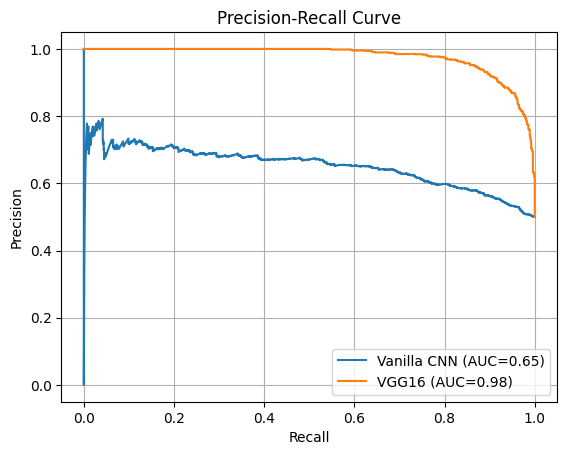

Vanilla CNN Test Loss: 0.6594315767288208
VGG16 Test Loss: 0.2153834104537964


In [17]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_pr_curve(model_preds, model_name):
    precision, recall, _ = precision_recall_curve(Y_true, model_preds)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{model_name} (AUC={pr_auc:.2f})')

plot_pr_curve(vanilla_model.predict(test_generator), "Vanilla CNN")
plot_pr_curve(vgg_model.predict(test_generator), "VGG16")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()
print("Vanilla CNN Test Loss:", vanilla_eval[0])
print("VGG16 Test Loss:", vgg_eval[0])

**Summary**

**What Did We Do?**

We taught a computer to tell if a picture is a cat or a dog.

**We used two methods:**
- Built our own simple model (Vanilla CNN).
- Used a smart, pre-trained model (VGG16) that already knows a lot about pictures.
Key Observations
- Smaller, balanced dataset: We used fewer images so the computer could learn quickly and fairly.
Both models learned to tell cats from dogs.

**The smart model (VGG16) was better:**
It made fewer mistakes and was more confident in its answers.
Suggestions
Use more pictures or mix them up: This helps the computer learn even better.
Try letting the smart model learn a bit more: It might get even better at spotting cats and dogs.
Check results in different ways: Don’t just look at how many it got right—see how well it finds all cats and all dogs.
Bottom Line:
Using a smart, pre-trained model helps the computer do a better job, even with fewer pictures. Mixing up the data and checking results carefully can make it even smarter!